In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=11

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\SAGAR\\Downloads\\Tomato_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

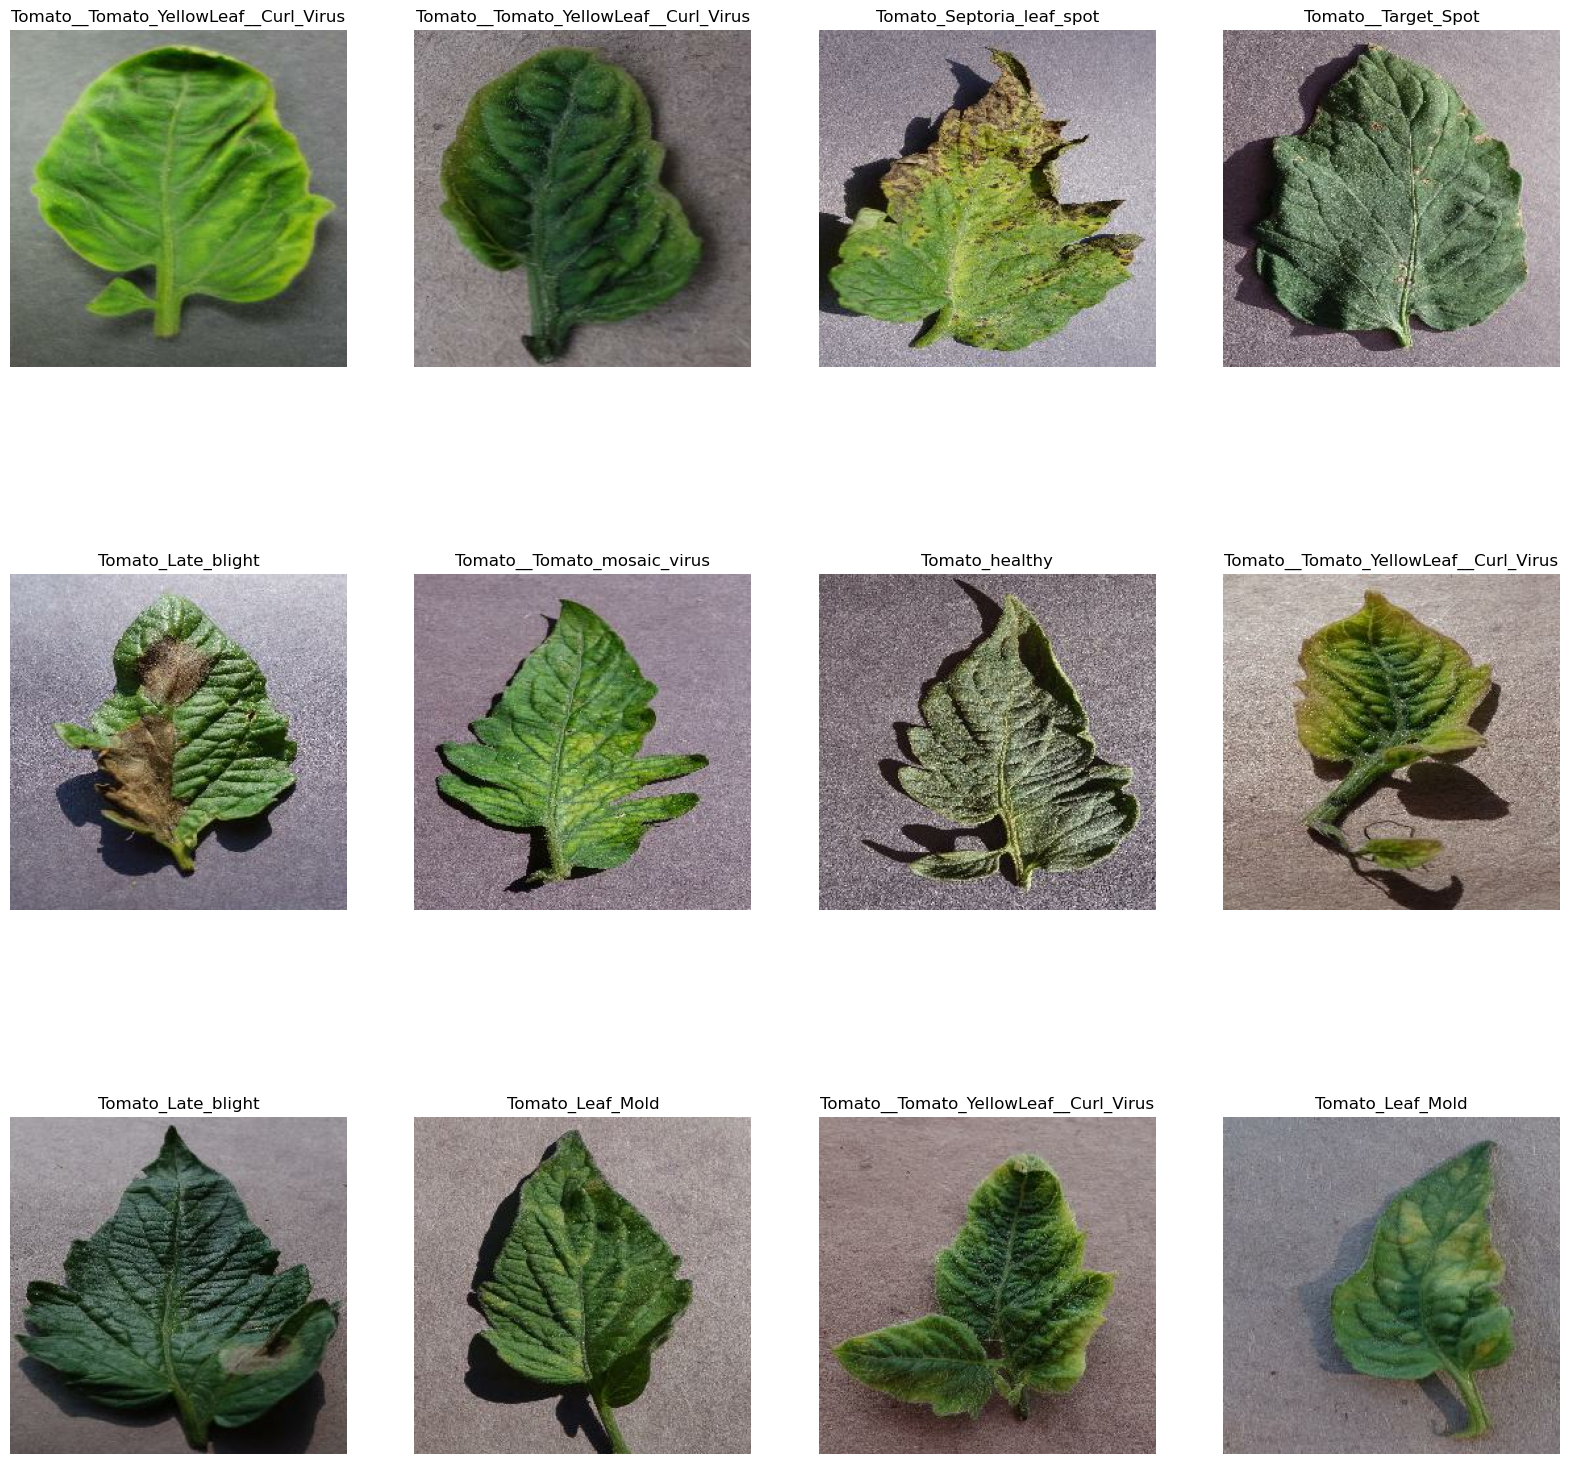

In [6]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_size=0.8
len(dataset)*train_size

400.8

In [8]:
train_ds=dataset.take(400)
len(train_ds)

400

In [9]:
test_ds=dataset.skip(400)
len(test_ds)

101

In [10]:
val_size=0.1
len(dataset)*val_size

50.1

In [11]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [12]:
test_ds=test_ds.skip(50)
len(test_ds)

51

In [13]:
#fun. for doing above work
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
     
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

400

In [16]:
len(test_ds)

51

In [17]:
#prefetch is used to make CPU and GPU work parallel(Optimal use of hardware resources)
#cache does open,read,map in first epoch and in further epocs it just train the model
train_ds=train_ds.cache() .shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#Converting RGB scale which is betn 0 to 255 into 0 to 1.
#Resizing will take care if the particular data which is not of ideal size(256X256)
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
#To make our model robust
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
#Using CNN
#No. of layers and 32,64,... are based on trail and error.
#Softmax-Normalize the probability of classes
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/11
400/400 [==============================] - 1856s 4s/step - loss: 1.6434 - accuracy: 0.4169 - val_loss: 1.3555 - val_accuracy: 0.5231
Epoch 2/11
400/400 [==============================] - 769s 2s/step - loss: 1.0693 - accuracy: 0.6209 - val_loss: 0.8622 - val_accuracy: 0.6775
Epoch 3/11
400/400 [==============================] - 773s 2s/step - loss: 0.7398 - accuracy: 0.7384 - val_loss: 0.8607 - val_accuracy: 0.7156
Epoch 4/11
400/400 [==============================] - 772s 2s/step - loss: 0.5690 - accuracy: 0.7990 - val_loss: 0.5494 - val_accuracy: 0.8006
Epoch 5/11
400/400 [==============================] - 1176s 3s/step - loss: 0.4539 - accuracy: 0.8413 - val_loss: 1.1102 - val_accuracy: 0.6750
Epoch 6/11
400/400 [==============================] - 865s 2s/step - loss: 0.3795 - accuracy: 0.8647 - val_loss: 0.5324 - val_accuracy: 0.8325
Epoch 7/11
400/400 [==============================] - 827s 2s/step - loss: 0.3499 - accuracy: 0.8759 - val_loss: 0.5959 - val_accuracy: 0.80

In [24]:
scores=model.evaluate(test_ds)

51/51 [==============================] - 90s 421ms/step - loss: 0.2544 - accuracy: 0.9087


In [25]:
scores

[0.2543814480304718, 0.9087010025978088]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 11, 'steps': 400}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

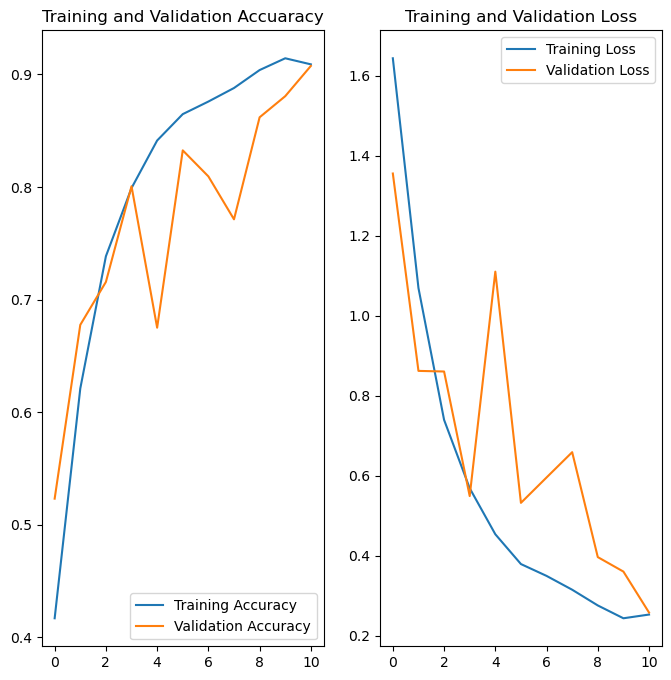

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuaracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 2s 2s/step
Predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


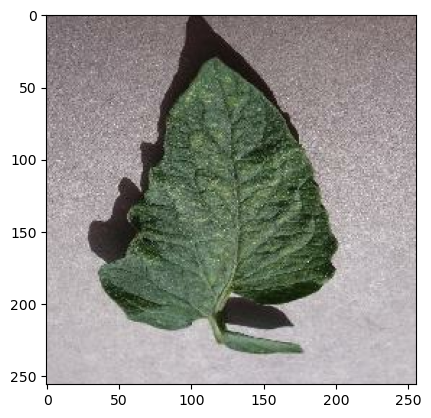

In [31]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
      
    predicted_class=class_names[np.argmax(predictions)]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 31ms/step


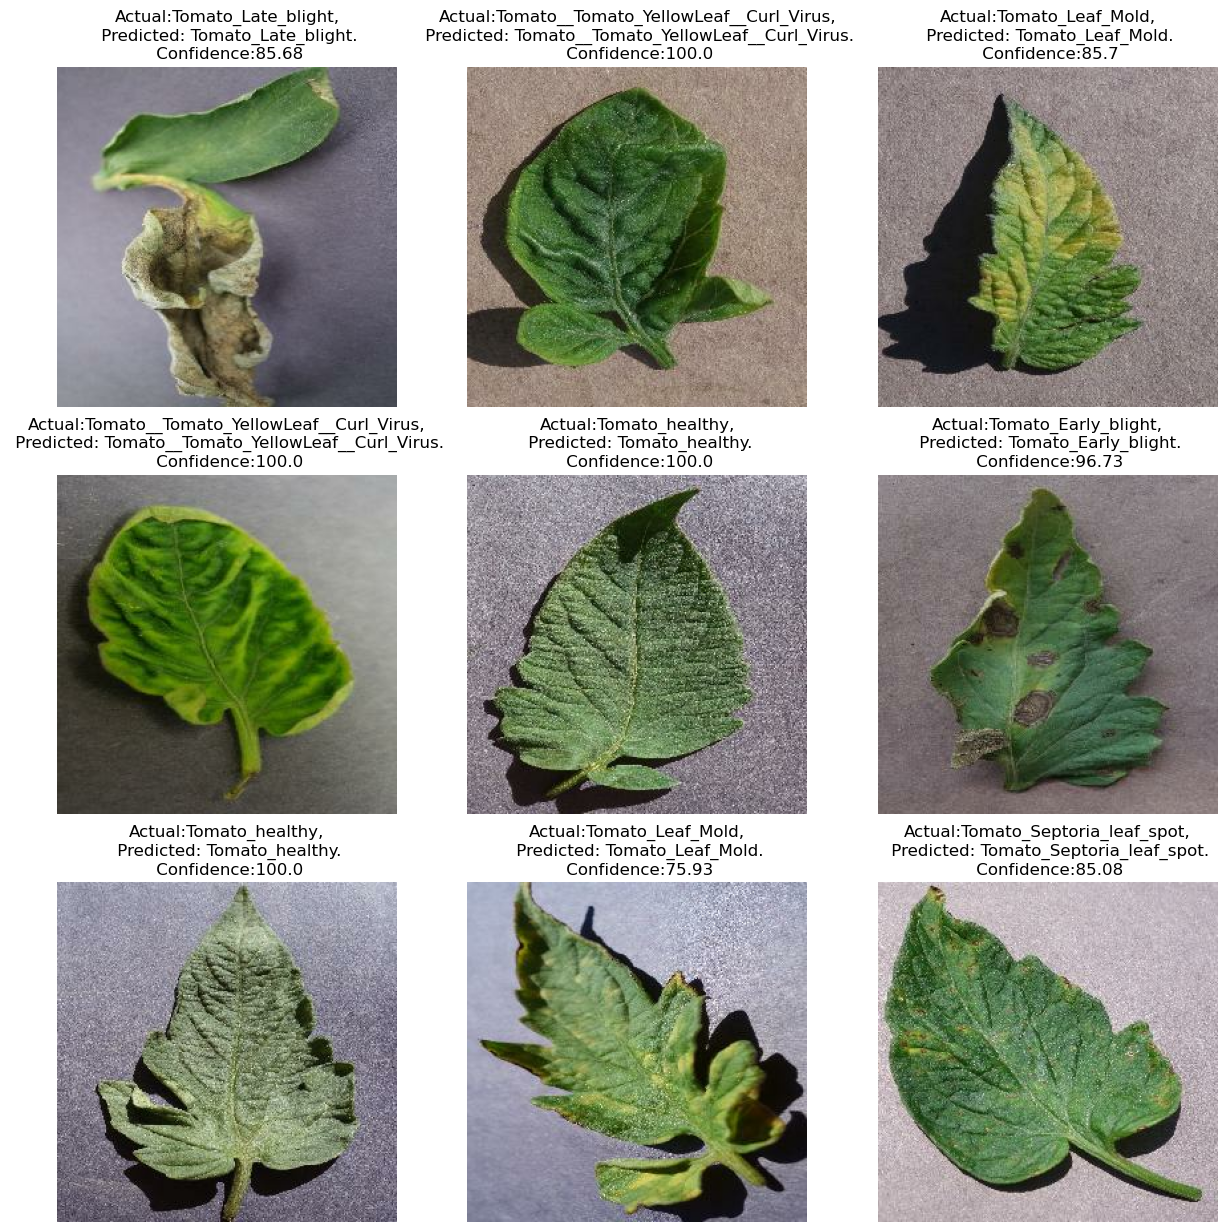

In [33]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}")
        plt.axis("off")

In [36]:
import os
model_version=max([int(i) for i in os.listdir("../Model")+[0]])+1
model.save(f"../Model/{model_version}")

INFO:tensorflow:Assets written to: ../Model/4\assets


INFO:tensorflow:Assets written to: ../Model/4\assets
